In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # get more colormaps
plt.style.use("bioAI.mplstyle")
import torch
import scipy
import tqdm

import sys
sys.path.append('../')
from methods import Hexagon, HexagonalGCs
from plotting_functions import set_size, project_cmap, minimal_ticks, scatter3d
from models import Similitude, JitterCI, JacobianCI

In [3]:
color_cycler = plt.rcParams['axes.prop_cycle'].by_key()['color']
#cmap = project_cmap()

In [4]:
dtype=torch.float32
ncells=100
model = JacobianCI(ncells=100,dtype=dtype,lr=1e-3, shift=0, p_magnitude=0)

In [5]:
def train_model(model):
    # Train model
    nsamples_space = 2**8
    loss_history = []
    metric_history = []
    phases_history = [model.phases.clone().detach().numpy()]
    G_history = []
    for epoch in tqdm.trange(5000):
        #if epoch == 3500:
        #    model.p_magnitude=0
        rs = model.unit_cell.sample(nsamples_space)
        rs = torch.tensor(rs,dtype=dtype)
        loss = model.train_step(rs)
        metric = model.CI_metric(r=rs).item()
        G_history.append(model.metric_tensor(model.jacobian(rs)).detach().numpy())
        loss_history.append(loss)
        phases_history.append(model.phases.clone().detach().numpy())
        metric_history.append(metric)
    phases_history[-1] = model.unit_cell.wrap(phases_history[-1])
    return loss_history, phases_history, metric_history, G_history

In [6]:
loss_history, phases_history, metric_history, G_history = train_model(model)
res=100
kde,_,_,_=model.phase_kde(res=res,bw_method=0.1)
loss_history = np.array(loss_history)
metric_history = np.array(metric_history)
phases_history = np.array(phases_history)
G_history = np.array(G_history)

100%|██████████| 5000/5000 [00:13<00:00, 384.22it/s]


In [7]:
kde.shape

(10000,)

In [8]:
np.log(metric_history[...,-1])

-20.506002500904906

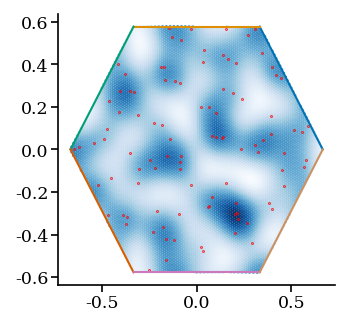

In [15]:
import copy
figsize=set_size(fraction=0.5,mode='square')
fig,ax = plt.subplots(figsize=figsize,dpi=150)
model.unit_cell.plot(ax=ax)
mesh = model.unit_cell.mesh(res)
ax.scatter(*mesh.T,c=kde)
ax.scatter(*phases_history[-1].T,c='red',s=0.1)